In [1]:
# Imports
import torch
import torchvision
import PIL
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

BATCH_SIZE = 128

# Load and Configure Dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) # (50000, 32, 32, 3)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True, num_workers = 6)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE, shuffle=False, num_workers = 6)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform) 
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE, shuffle=False, num_workers = 6)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [2]:
# Define CNN Architecture

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 5, padding=2)
    self.conv2 = nn.Conv2d(64, 64, 5, padding=2)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv4 = nn.Conv2d(128, 128, 3, padding=1) 
    self.pool = nn.MaxPool2d(2, 2) 
    self.fc1 = nn.Linear(64 * 128, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)

    self.bn_conv1 = nn.BatchNorm2d(64)
    self.bn_conv2 = nn.BatchNorm2d(64)
    self.bn_conv3 = nn.BatchNorm2d(128)
    self.bn_conv4 = nn.BatchNorm2d(128)
    self.bn_dense1 = nn.BatchNorm1d(1024)
    self.bn_dense2 = nn.BatchNorm1d(512)
    
    self.dropout_conv = nn.Dropout2d(p=0.25)
    self.dropout_dense = nn.Dropout1d(p=0.30)

  def conv_layers(self, x):
    out = F.relu(self.bn_conv1(self.conv1(x)))
    out = F.relu(self.bn_conv2(self.conv2(out)))
    out = self.pool(out)
    out = self.dropout_conv(out)
    out = F.relu(self.bn_conv3(self.conv3(out)))
    out = F.relu(self.bn_conv4(self.conv4(out)))
    out = self.pool(out)
    out = self.dropout_conv(out)
    return out

  def dense_layers(self, x):
    out = F.relu(self.bn_dense1(self.fc1(x)))
    out = self.dropout_dense(out)
    out = F.relu(self.bn_dense2(self.fc2(out)))
    out = self.dropout_dense(out)
    out = self.fc3(out)
    return out

  def forward(self, x):
    out = self.conv_layers(x)
    out = out.view(-1, 128 * 8 * 8)
    out = self.dense_layers(out)
    return out

net = Net()
device = 'cpu'
net.to(device)


num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

Number of trainable parameters: 9252170


In [5]:
import torch.optim as optim
num_epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

for epoch in range(num_epochs):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

[epoch 1] loss: 0.01686 accuracy: 0.2041 val loss: 0.01425 val accuracy: 0.3666
[epoch 2] loss: 0.01502 accuracy: 0.2729 val loss: 0.01309 val accuracy: 0.4177
[epoch 3] loss: 0.01435 accuracy: 0.3049 val loss: 0.01192 val accuracy: 0.5128
[epoch 4] loss: 0.01372 accuracy: 0.3378 val loss: 0.00998 val accuracy: 0.6122
[epoch 5] loss: 0.01317 accuracy: 0.3661 val loss: 0.00986 val accuracy: 0.6142
[epoch 6] loss: 0.01280 accuracy: 0.3800 val loss: 0.00844 val accuracy: 0.6918
[epoch 7] loss: 0.01251 accuracy: 0.3943 val loss: 0.00800 val accuracy: 0.6970
[epoch 8] loss: 0.01223 accuracy: 0.4083 val loss: 0.00774 val accuracy: 0.7188
[epoch 9] loss: 0.01203 accuracy: 0.4180 val loss: 0.00716 val accuracy: 0.7338
[epoch 10] loss: 0.01179 accuracy: 0.4263 val loss: 0.00699 val accuracy: 0.7457
[epoch 11] loss: 0.01159 accuracy: 0.4375 val loss: 0.00706 val accuracy: 0.7242
[epoch 12] loss: 0.01139 accuracy: 0.4447 val loss: 0.00669 val accuracy: 0.7438
[epoch 13] loss: 0.01118 accuracy: 0.

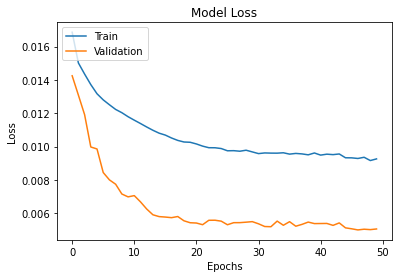

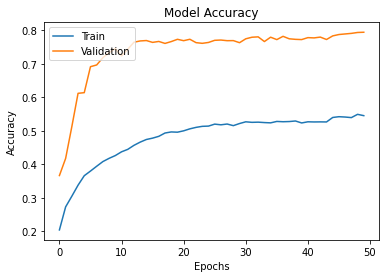

In [6]:
import matplotlib.pyplot as plt

legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

In [11]:
torch.save(net.state_dict(), 'checkpoint.pth')
#net.load_state_dict(torch.load('checkpoint.pth'))

<All keys matched successfully>

In [11]:
pred_vec = []
correct = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = net(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_set)))

Accuracy on the 10000 test images: 78.19 %


In [41]:
# Adversarial Attacks

#Reload data with batch size=1 for FGSM only
test_loader = torch.utils.data.DataLoader(dataset = test_set,batch_size = 1, shuffle = True) 
eps = 0.1

def FGSM(img,gradient,e):
    signs = gradient.sign() #Extract the gradient signs
    # Create the perturbed image by adjusting each pixel of the input image
    x_perturb = img + e*signs #Create our perturbered image by adding a small epsilon in the direction of the gradient
    image_attack = torch.clamp(x_perturb, 0, 1) #Clamp the image pixel value to make sure its an image
    return image_attack #Return our final attacked image

def attack_network(dev,loader,e,number):
    accur = []
    sample=0
    iter=0
    for i, (imgs, classes) in enumerate(loader):
        if i % 100 == 0: 
            print("On Iteration ",iter )
        classes = classes.to(dev)
        imgs = imgs.to(dev)
        imgs.requires_grad=True
        out = net(imgs)
        class_hat = out.max(1, keepdim=True)[1] #Initial Label Prediction
        #Attack the network only if it already predicts the image class correctly
        if classes.item()==class_hat.item(): 
            #Calculate the current value of the loss
            loss_value = criterion(out, classes) 
            # Do Backproprogation using SGD to update weights based on loss
            optimizer.zero_grad() #Set gradient to zero before each weight update
            loss_value.backward() #Find value of new gradients based on current loss value
            gradients = imgs.grad.data #Get current gradients
            #Attack the network using FGSM
            img_attack=FGSM(imgs,gradients,e)
            class_hat_attack=net(img_attack) #Get new network prediction with attack
            attack_pred = class_hat_attack.data.max(1, keepdim=True)[1]#Initial Prediction
            if attack_pred.item()==classes.item():
                accur.append(1)
        sample += classes.size(0)
        iter+=1
    accur=np.array(accur)
    ac_total=(100 * np.sum(accur) / sample)
    print(ac_total.shape)
    print("Accuracy for Epsilon ={}".format(e,ac_total)) #Observe how accuracy is changing with FGSM attack
    return ac_total
accur_store=attack_network(device,test_loader,eps,1)


On Iteration  0
On Iteration  100
On Iteration  200
On Iteration  300
On Iteration  400
On Iteration  500
On Iteration  600
On Iteration  700
On Iteration  800
On Iteration  900
On Iteration  1000
On Iteration  1100
On Iteration  1200
On Iteration  1300
On Iteration  1400
On Iteration  1500
On Iteration  1600
On Iteration  1700
On Iteration  1800
On Iteration  1900
On Iteration  2000
On Iteration  2100
On Iteration  2200
On Iteration  2300
On Iteration  2400
On Iteration  2500
On Iteration  2600
On Iteration  2700
On Iteration  2800
On Iteration  2900
On Iteration  3000
On Iteration  3100
On Iteration  3200
On Iteration  3300
On Iteration  3400
On Iteration  3500
On Iteration  3600
On Iteration  3700
On Iteration  3800
On Iteration  3900
On Iteration  4000
On Iteration  4100
On Iteration  4200
On Iteration  4300
On Iteration  4400
On Iteration  4500
On Iteration  4600
On Iteration  4700
On Iteration  4800
On Iteration  4900
On Iteration  5000
On Iteration  5100
On Iteration  5200
On It

In [43]:
accur_store

4.08

In [49]:
from torchattacks import PGD
#Note: This function was obtained from the utils.py file from the torchattacks repository cited above
def get_pred(model, images, device):
    logits = model(images.to(device))
    _, pres = logits.max(dim=1)
    return pres.cpu()

test_loader = torch.utils.data.DataLoader(dataset = test_set,batch_size = BATCH_SIZE, shuffle = True)

atck_net = PGD(net, eps=8/255, alpha=2/225, steps=10, random_start=True)
ac=0
sample=0
count=0
for imgs,classes in test_loader:
    imgs_attack=atck_net(imgs, classes)
    prediction=get_pred(net, imgs_attack, device)
    for j in range(prediction.shape[0]):
        if prediction[j]==classes[j]:
            ac+=1
    sample += classes.size(0)
    count+=1

accur= 100*np.sum(ac)/sample
print("PGD Attack Testing Accuracy:",accur)

PGD Attack Testing Accuracy: 0.04


In [7]:
from torchattacks import GN
import numpy as np
#Note: This function was obtained from the utils.py file from the torchattacks repository cited above
def get_pred(model, images, device):
    logits = model(images.to(device))
    _, pres = logits.max(dim=1)
    return pres.cpu()

test_loader = torch.utils.data.DataLoader(dataset = test_set,batch_size = BATCH_SIZE, shuffle = True)

atck_net = GN(net, std=0.15)
ac=0
sample=0
count=0
for imgs,classes in test_loader:
    imgs_attack=atck_net(imgs, classes)
    prediction=get_pred(net, imgs_attack, device)
    for j in range(prediction.shape[0]):
        if prediction[j]==classes[j]:
            ac+=1
    sample += classes.size(0)
    count+=1

accur= 100*np.sum(ac)/sample
print("GN Attack Testing Accuracy:",accur)

GN Attack Testing Accuracy: 34.36


In [16]:
# Adversarial Defense
import torch.optim as optim
from torchattacks import PGD

num_epochs = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True, num_workers = 6) # 16 ?

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

atck_net = PGD(net, eps=8/255, alpha=2/225, steps=10, random_start=True)

for epoch in range(num_epochs):
  running_loss = 0.0
  correct = 0
  for data in train_loader:

    batch, labels = data # imgs, classes
    batch=atck_net(batch, labels)

    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))


[epoch 1] loss: 0.01826 accuracy: 0.0950 val loss: 0.14395 val accuracy: 0.0951
[epoch 2] loss: 0.01657 accuracy: 0.2099 val loss: 0.09718 val accuracy: 0.5926
[epoch 3] loss: 0.01585 accuracy: 0.2308 val loss: 0.08851 val accuracy: 0.6330
[epoch 4] loss: 0.01552 accuracy: 0.2470 val loss: 0.08565 val accuracy: 0.6801
[epoch 5] loss: 0.01523 accuracy: 0.2613 val loss: 0.08193 val accuracy: 0.6799


In [20]:
# Testing after adversarial Training

from torchattacks import GN
#Note: This function was obtained from the utils.py file from the torchattacks repository cited above
def get_pred(model, images, device):
    logits = model(images.to(device))
    _, pres = logits.max(dim=1)
    return pres.cpu()

test_loader = torch.utils.data.DataLoader(dataset = test_set,batch_size = BATCH_SIZE, shuffle = True)

atck_net = PGD(net, eps=8/255, alpha=2/225, steps=10, random_start=True)
ac=0
sample=0
count=0
for imgs,classes in test_loader:
    imgs_attack=atck_net(imgs, classes)
    prediction=get_pred(net, imgs_attack, device)
    for j in range(prediction.shape[0]):
        if prediction[j]==classes[j]:
            ac+=1
    sample += classes.size(0)
    count+=1

accur= 100*np.sum(ac)/sample
print("PGD Attack Testing Accuracy:",accur)

PGD Attack Testing Accuracy: 23.41
